In [1]:
# Here we take care of paths.

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-16:] == 'image-to-tex-OCR':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in Paragraph_to_Tex folder
print('Current path:' + os.getcwd())

Starting path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR/Jupyter_Notebooks
Current path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR


In [2]:
from Data.Data_Module import Data_Module
from Models.Printed_Tex_Transformer import ResNetTransformer
from Lightning_Models.Printed_Tex_Lit_Model import LitResNetTransformer
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from PIL import Image
import torch
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import transforms
from PIL import Image
from IPython.display import display, Math
from Data.image_transforms import Image_Transforms
import cv2
import cv2
import PIL
import numpy as np
transform = transforms.ToPILImage()



dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


/Users/gregory/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Generate Data Module by uploading images and formulas
# images need to be in the folder Data/Data_Bank/generated_png_images
# formulas need to be in Data/Data_Bank/final_png_formulas.txt
# image filenames need to be in Data/Data_Bank/corresponding_png_images.txt

dataset = Data_Module(stage = 'fit',
                 set_max_label_length = 128,
                 number_png_images_to_use_in_dataset=250*1000,
                 labels_transform='default',
                image_transform_name ='alb',
                 train_val_fraction = 0.999,
                   vocabulary_path = 'Tokenizer/230k_ver2.json',
                load_vocabulary = True,
                      image_padding = True,
                      max_width = 10*1000,


                 batch_size = 128,
                num_workers = 8,
                data_on_gpu = True,
                )

In [4]:
print( 
    'Vocabulary size:',len(dataset.vocabulary),
    '\nMax label length:', dataset.max_label_length,
    "\nStart <S> goes to index ",dataset.vocabulary['<S>'],
      "\nEnd <E> goes to index ",dataset.vocabulary['<E>'],
      "\nPadding <P> goes to index ",dataset.vocabulary['<P>'],
)

Vocabulary size: 581 
Max label length: 130 
Start <S> goes to index  0 
End <E> goes to index  1 
Padding <P> goes to index  2


In [5]:


# HELPER FUNCTIONS
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s +" " + str(letter)
    return s

In [6]:
model = ResNetTransformer(dataset=dataset).to(dev)
# N_Inverted_128seq_1128Height_256embed_resnet34_4layers_8ratio_4
model.load_state_dict(torch.load(("Models_Parameters_Log/resize128by1024_resnet34_6trans_1.pth"), map_location=torch.device('cpu')))
lit_model = LitResNetTransformer(model=model, WandB=False)
lit_model.eval()
lit_model.freeze()
scripted_save = lit_model.to_torchscript()
torch.jit.save(scripted_save, "Models_Parameters_Log/scripted_model1.pt")


/Users/gregory/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gregory/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/Users/gregory/anaconda3/lib/python3.10/site-packages/torch/jit/_recursive.py:266: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "


In [7]:
scripted = torch.jit.load("Models_Parameters_Log/scripted_model1.pt")

In [14]:
import albumentations
from albumentations.augmentations.geometric.resize import Resize
import torch.nn.functional as F

MAX_RATIO = 8
GOAL_HEIGHT = 128

def find_ratio(h, w, goal):
    return goal/h
    


def predict(image_path):
   
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    #image = cv2.bitwise_not(image)
    #h, w, c = image.shape
    #ratio =w / h
    #if ratio == 0:
        #ratio = 1 
    #if ratio > MAX_RATIO:
        #ratio = MAX_RATIO
        
    #new_h = GOAL_HEIGHT
    #new_w = int(new_h * ratio)
    #image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
    #print(image.shape)


    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image'][:1]
    print(display(transform(image_tensor)))
    
    #max_H = 128
    #max_W = 1024

    #image_tensor = F.pad(image_tensor, (0, max_W - new_w, 0, max_H - new_h), value=0)

    
    print(image_tensor.shape)
    print(display(transform(image_tensor)))
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))



def predict_inverted(image_path):
   
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    h, w, c = image.shape
    image = cv2.bitwise_not(image)
    
    ratio =w / h
    if ratio == 0:
        ratio = 1 
    if ratio > MAX_RATIO:
        ratio = MAX_RATIO
        
    
    new_h = GOAL_HEIGHT
    new_w = int(new_h * ratio)
    image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
    print(image.shape)


    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image'][:1]
    print(display(transform(image_tensor)))
    
    max_H = 128
    max_W = 1024

    image_tensor = F.pad(image_tensor, (0, max_W - new_w, 0, max_H - new_h), value=0)

    
    print(image_tensor.shape)
    print(display(transform(image_tensor)))
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))

    
    
    
def predict_simple(image_path):
   
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    h, w, c = image.shape
    #ratio =w / h
    #if ratio == 0:
        #ratio = 1 
    #if ratio > MAX_RATIO:
        #ratio = MAX_RATIO
        ##new_h = GOAL_HEIGHT
        #new_w = int(new_h * ratio)
        #image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
    
    print(image.shape)


    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image']#[:1]
    print(display(transform(image_tensor)))
    
    print(image_tensor.shape)
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))

    
    
    
    
    
def predict_scaled(image_path):
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    h, w, c = image.shape
    ascpect = w/h
    if ascpect == 0:
        ascpect = 1 
    if ascpect > MAX_RATIO:
        ascpect = MAX_RATIO
    
    downscale = GOAL_HEIGHT/h
    image = cv2.resize(image, (0,0), fx=downscale, fy=downscale,interpolation=cv2.INTER_LINEAR)
   
    print(image.shape)
    



    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image'][:1]
    max_H = 128
    max_W = 1024

    #if h<128 and w<1024:
        #image_tensor = F.pad(image_tensor, (0, max_W - w, 0, max_H - h), value=0)

    print(display(transform(image_tensor)))
    print(image_tensor.shape)
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))

    
# HELPER FUNCTIONS
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s +" " + str(letter)
    return s
    

In [15]:
IMAGES= [#'Jupyter_Notebooks/test_photos/79a37d9d8b727e9.png',
         #"Jupyter_Notebooks/test_photos/S201.png",
          #"Jupyter_Notebooks/test_photos/202.png",
           "Jupyter_Notebooks/test_photos/203.png",
         "Jupyter_Notebooks/test_photos/qqq.png",
         "Jupyter_Notebooks/test_photos/zarhin.png",
         "Jupyter_Notebooks/test_photos/my_image.png",
         "Jupyter_Notebooks/test_photos/screenshot_1.png",
         "Jupyter_Notebooks/test_photos/screenshot_3.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_14.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_10.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_13.png",
          "Jupyter_Notebooks/test_photos/Screen Shot_11.png",
         "Jupyter_Notebooks/test_photos/screenshot_2.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_18.png",
        'Jupyter_Notebooks/test_photos/128.png',
         'Jupyter_Notebooks/test_photos/128_2.png',
         'Jupyter_Notebooks/test_photos/image_3.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_15.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_11.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_16.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_17.png',
         'Jupyter_Notebooks/test_photos/screenshot_2.png',
         'Jupyter_Notebooks/test_photos/ratio25.png',
         'Jupyter_Notebooks/test_photos/ratio31.png',
        'Jupyter_Notebooks/test_photos/ratio76.png',
         
    

]

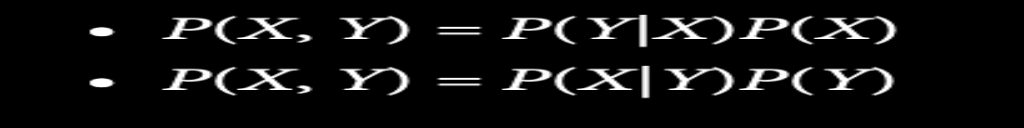

None
torch.Size([1, 128, 1024])


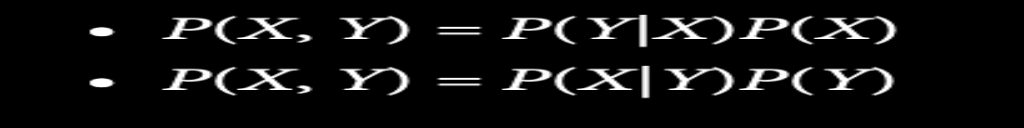

None

Predicted formula:
 <S> \begin{array} { c } { \cdot P ( X , Y ) = P ( Y 0 X ) P ( X ) } \\ { \cdot P ( X , Y ) = P ( X ) P ( Y ) } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


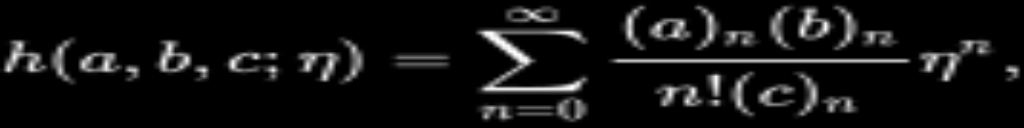

None
torch.Size([1, 128, 1024])


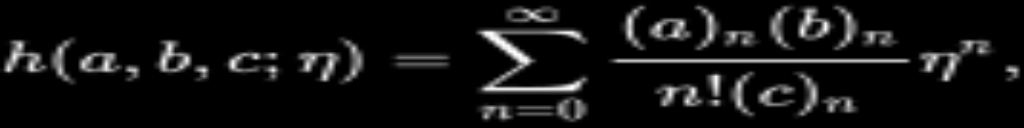

None

Predicted formula:
 <S> h ( a , b , c ; q ) = \sum _ { n = 0 } ^ { \infty } \frac { ( a ) _ { \pi } ( b ) _ { \pi } } { n ! ( e ) _ { n } } \eta ^ { \pi } , <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


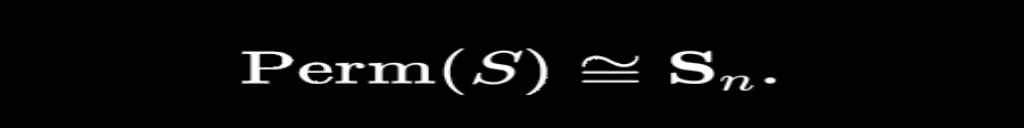

None
torch.Size([1, 128, 1024])


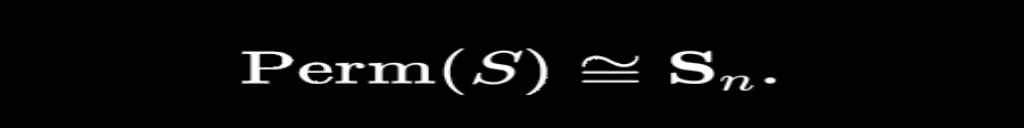

None

Predicted formula:
 <S> \mathrm { P e r m } ( S ) \cong { \bf S } _ { n } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


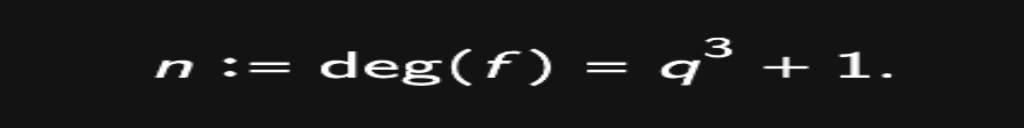

None
torch.Size([1, 128, 1024])


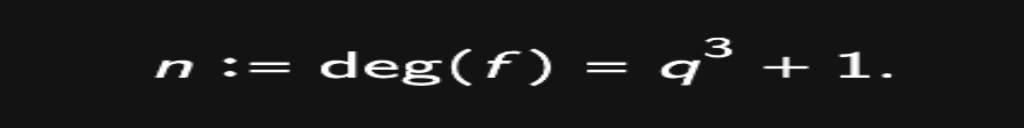

None

Predicted formula:
 <S> n : = \mathrm { d e g } ( f ) = q ^ { 2 } + 1 . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


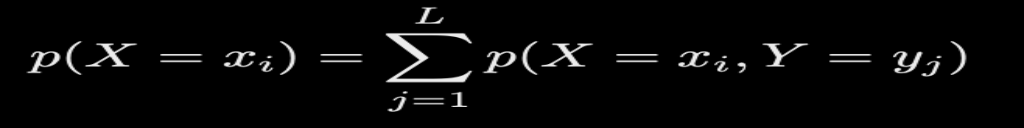

None
torch.Size([1, 128, 1024])


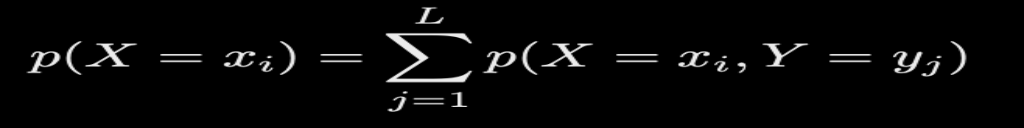

None

Predicted formula:
 <S> p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , Y = y _ { j } ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


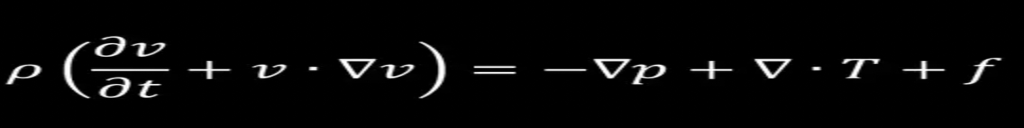

None
torch.Size([1, 128, 1024])


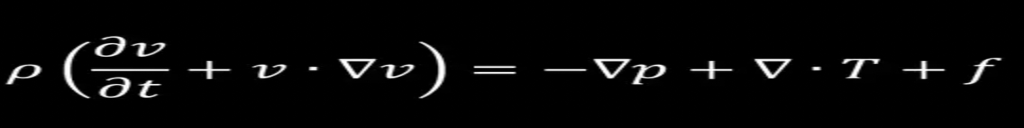

None

Predicted formula:
 <S> \rho \left( \frac { \partial v } { \partial t } + v \cdot \nabla v \right) = - \nabla p \cdot r \cdot \tau \cdot f <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


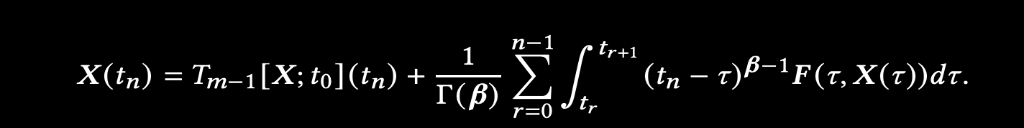

None
torch.Size([1, 128, 1024])


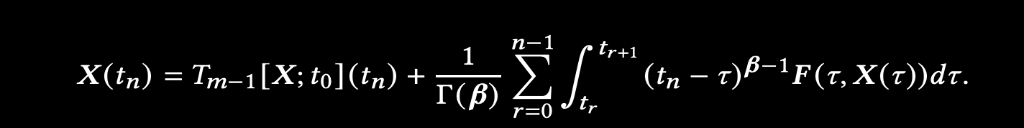

None

Predicted formula:
 <S> X ( t _ { n } ) = T _ { m - 1 } ( X ; t _ { 0 } ) + \frac { 1 } { \Gamma ( \theta ) } \sum _ { r = 0 } ^ { r - 1 } \int _ { r = 0 } ^ { r - 1 } \int _ { r _ { r } } ^ { t _ { r + 1 } } ( t _ { n } - r ) ^ { \theta - 1 } P ( \tau , X ( r ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


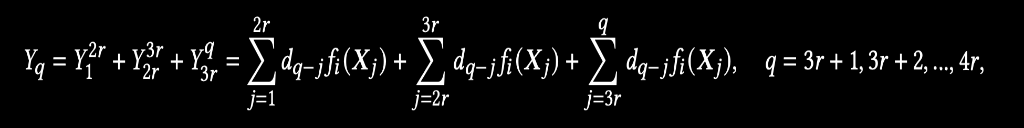

None
torch.Size([1, 128, 1024])


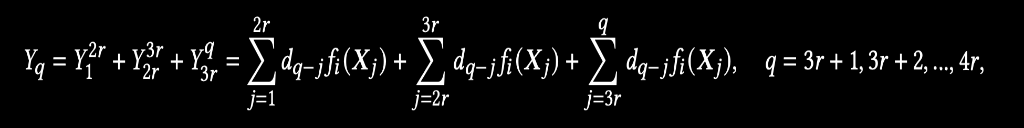

None

Predicted formula:
 <S> Y _ { q } = Y _ { 1 } ^ { p r } \star \chi _ { 2 p } ^ { W } \star \chi _ { j } ^ { q } = \sum _ { j = 1 } ^ { p r } d _ { r } f ( X _ { j } ) \star \sum _ { j = 2 r } ^ { 2 r } d _ { r - j l } ( X _ { j } ) \star \sum _ { j = 1 } ^ { q } d _ { r } f ( X ) , \quad q = 3 r \star 1 , 2 r + 2 , . .


<IPython.core.display.Math object>

None


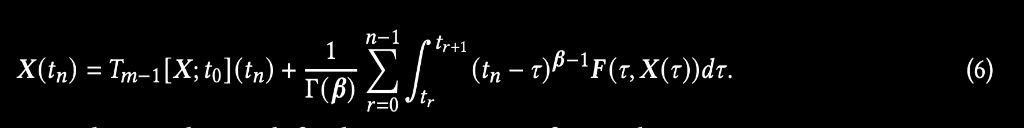

None
torch.Size([1, 128, 1024])


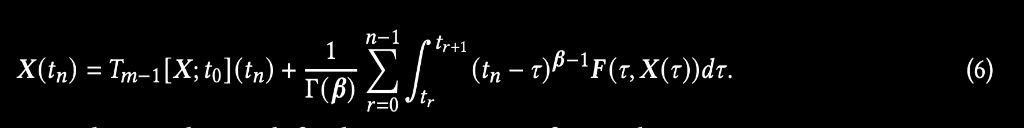

None

Predicted formula:
 <S> X ( t _ { o } ) = T _ { m - 1 } [ X ; t _ { 0 } ] ( t _ { o } ) \star \frac { 1 } { \Gamma ( \bar { \theta } ) } \sum _ { n = 0 } ^ { r - 1 } \int _ { r _ { r } } ^ { t _ { r + 1 } } ( t _ { n } - r ) ^ { p - 1 } P ( t , X ( r ) d t . \tag { 6 } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


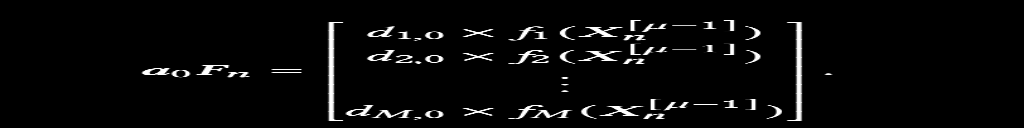

None
torch.Size([1, 128, 1024])


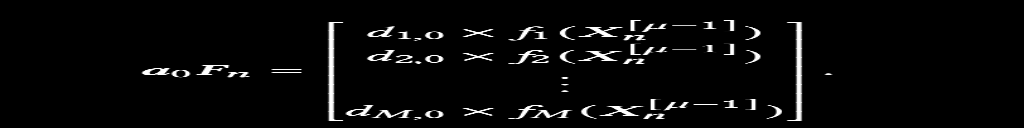

None

Predicted formula:
 <S> a _ { 0 } F _ { n } = \left[ \begin{array} { c } { d _ { 1 } \approx f _ { 1 } ( X _ { \mu } ^ { \mu - 1 ) } } \\ { d _ { 2 } \otimes \lambda _ { 1 } \times F _ { 1 } ^ { \mu - 1 } ) } \\ { d _ { 2 } \otimes \lambda _ { 1 } \times F _ { 2 } ^ { \mu \nu - 1 } ( X ^ { \mu \nu - 1 } ) } \\ \end{array} \right] . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


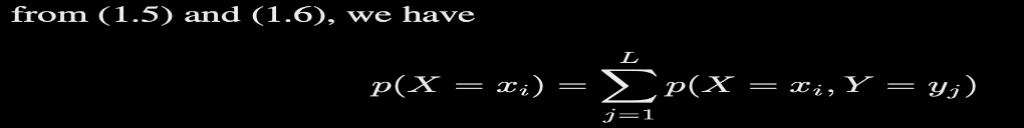

None
torch.Size([1, 128, 1024])


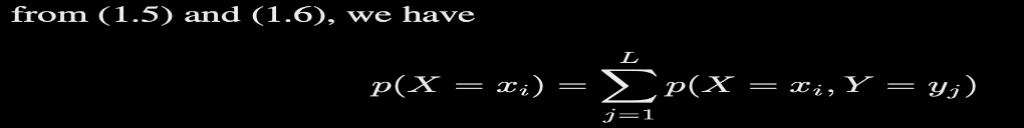

None

Predicted formula:
 <S> \begin{array} { l } { \mathrm { f o m } \left( 1 , S \right) \mathrm { i n d } \left( 1 , 8 \right) , \mathrm { w e r h e } } \\ { p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , Y = y _ { j } ) } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


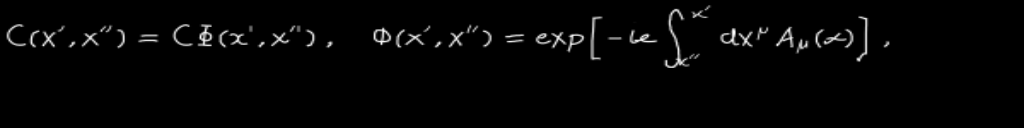

None
torch.Size([1, 128, 1024])


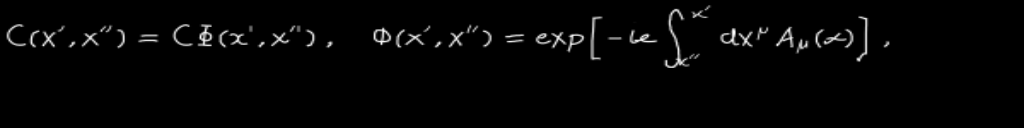

None

Predicted formula:
 <S> \zeta _ { ( K ^ { \prime } \kappa ^ { \prime } ) = \zeta \tilde { 4 } ( { \bf x } _ { + } ^ { \prime } { \bf x } ^ { \prime } ) \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \, \,


<IPython.core.display.Math object>

None


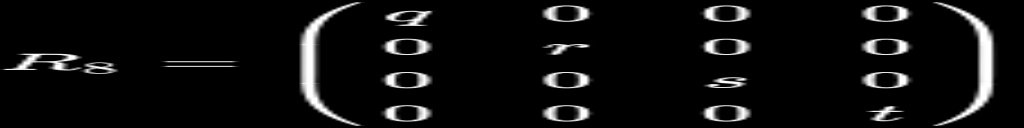

None
torch.Size([1, 128, 1024])


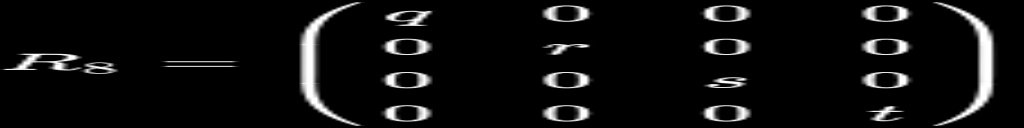

None

Predicted formula:
 <S> R _ { 8 } = \left( \begin{array} { c c c } { q } & { 0 } & { 0 } \\ { 0 } & { r } & { 0 } & { 0 } \\ { 0 } & { 0 } & { 0 } & { 0 } \\ { 0 } & { 0 } & { 0 } & { t } \\ \end{array} \right) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


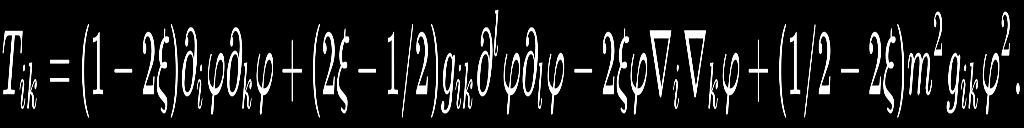

None
torch.Size([1, 128, 1024])


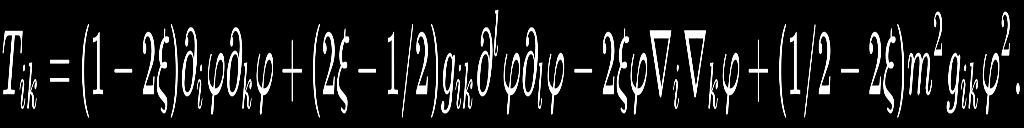

None

Predicted formula:
 <S> T _ { i k } = ( 1 - 2 \xi ) \partial _ { i } \varphi \partial _ { k } \varphi + ( 2 \xi - 1 / 2 ) g _ { i k } \partial ^ { l } \varphi \partial _ { l } \varphi - 2 \xi \varphi \nabla _ { i } \nabla _ { k } \varphi + ( 1 / 2 - 2 \xi ) m ^ { 2 } g _ { i k } \varphi ^ { 2 } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


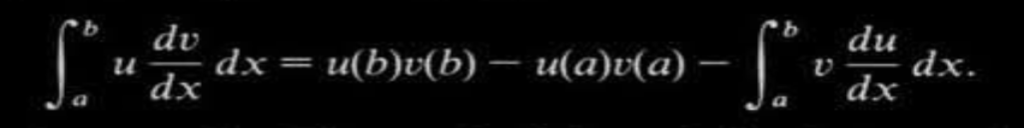

None
torch.Size([1, 128, 1024])


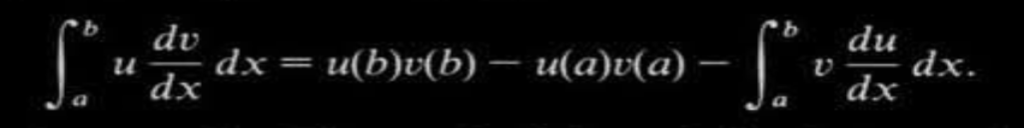

None

Predicted formula:
 <S> \int _ { x } ^ { s } u \, \frac { d v } { d \chi } \, d \chi = u ( \partial ) v ( \partial ) - u ( a ) v ( d ) - \left[ \begin{array} { c } { s } \\ { x } \\ \end{array} \right] ^ { s } v \, \frac { d u } { d \chi } \, d \chi . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


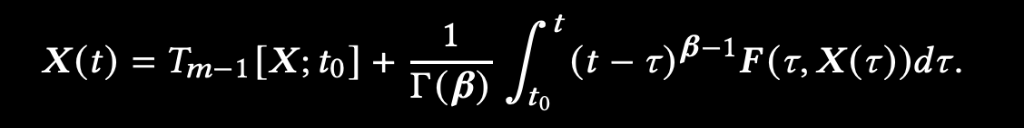

None
torch.Size([1, 128, 1024])


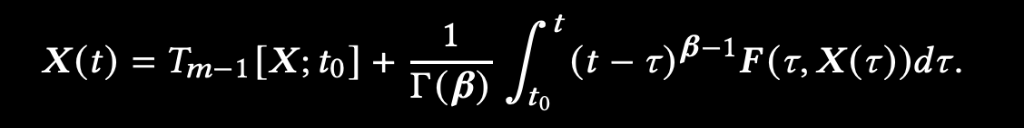

None

Predicted formula:
 <S> X ( t ) = T _ { m - 1 } [ X ; t _ { 0 } ] \star \frac { 1 } { \Gamma ( \beta ) } \int _ { t _ { 0 } } ^ { t } ( t - \tau ) ^ { \theta - 1 } F ( \tau , X ( \tau ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


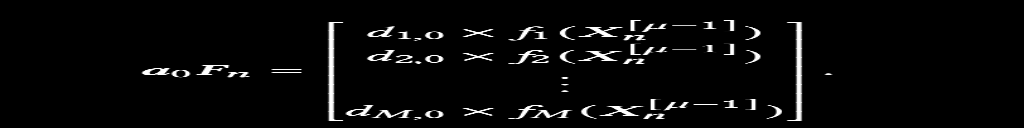

None
torch.Size([1, 128, 1024])


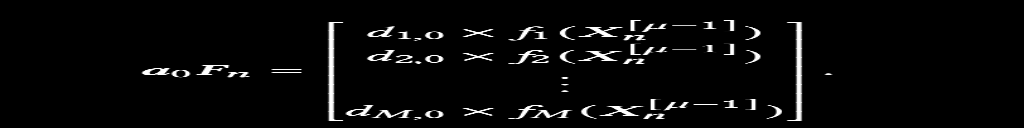

None

Predicted formula:
 <S> a _ { 0 } F _ { n } = \left[ \begin{array} { c } { d _ { 1 } \approx f _ { 1 } ( X _ { \mu } ^ { \mu - 1 ) } } \\ { d _ { 2 } \otimes \lambda _ { 1 } \times F _ { 1 } ^ { \mu - 1 } ) } \\ { d _ { 2 } \otimes \lambda _ { 1 } \times F _ { 2 } ^ { \mu \nu - 1 } ( X ^ { \mu \nu - 1 } ) } \\ \end{array} \right] . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


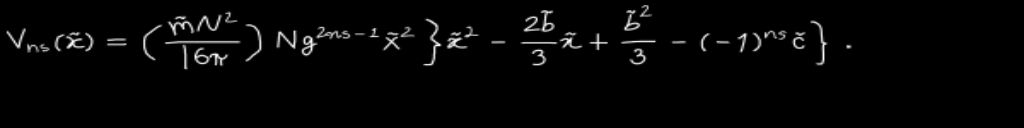

None
torch.Size([1, 128, 1024])


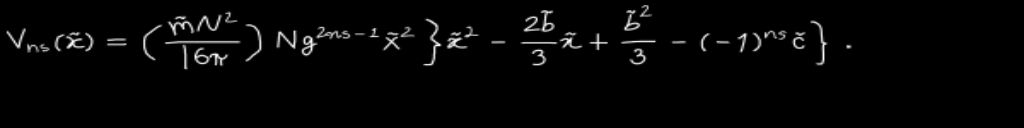

None

Predicted formula:
 <S> { \cal V } _ { \mathrm { e v } } ( \tilde { \cal E } ) = \left( \frac { \tilde { \nabla } ( \Lambda ^ { \prime } ) ^ { 2 } } { | \tilde { \Theta } _ { \mathrm { o } } } \right) \, \mathrm { t h } ^ { 2 n - 1 } \tilde { \cal R } ^ { 2 } - \frac { 2 \tilde { R } } { 2 } \tilde { \cal R } + \frac { \tilde { E } ^ { 2 } } { 2 } - ( - t ) ^ { n } \tilde { G } \right] \ . <E> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


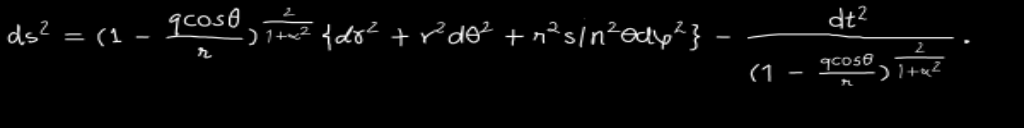

None
torch.Size([1, 128, 1024])


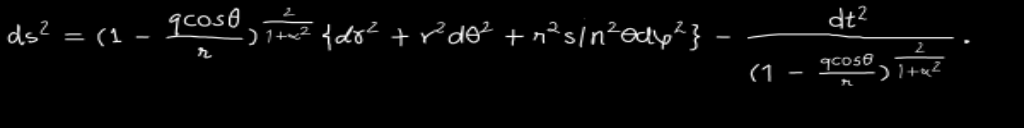

None

Predicted formula:
 <S> \mathrm { d } s ^ { 2 } = ( 1 - \frac { 7 8 4 } { \hbar } ) ^ { \frac { 1 } { 1 + 8 } } ( k ^ { 2 } + V ^ { 2 } d \Theta ^ { 2 } + r ^ { 2 } s / \alpha ^ { 2 } { \cal R } ( s ) ^ { 2 } - \frac { 4 \xi ^ { 2 } } { \kappa } ) ^ { \frac { 1 } { 1 + 8 } } } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


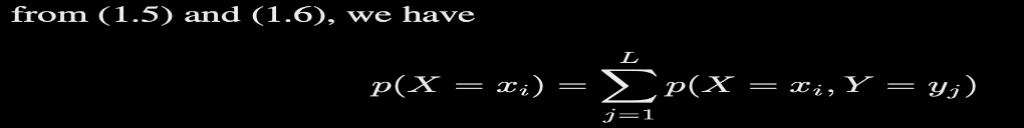

None
torch.Size([1, 128, 1024])


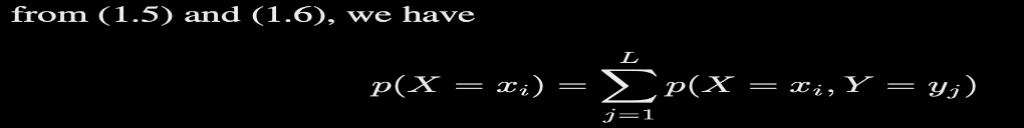

None

Predicted formula:
 <S> \begin{array} { l } { \mathrm { f o m } \left( 1 , S \right) \mathrm { i n d } \left( 1 , 8 \right) , \mathrm { w e r h e } } \\ { p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , Y = y _ { j } ) } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


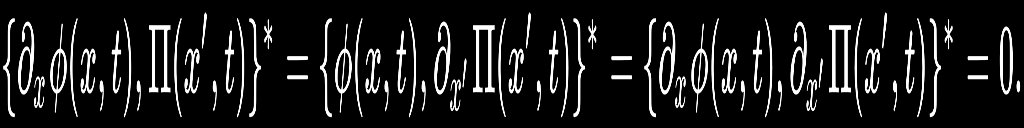

None
torch.Size([1, 128, 1024])


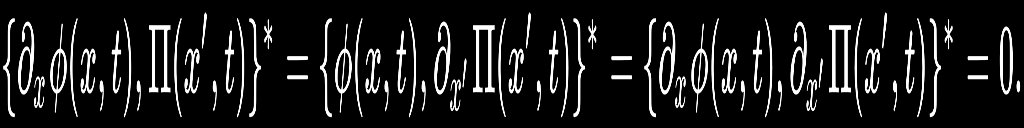

None

Predicted formula:
 <S> \{ \partial _ { x } \phi ( x , t ) , \Pi ( x ^ { \prime } , t ) \} ^ { * } = \{ \phi ( x , t ) , \partial _ { x ^ { \prime } } \Pi ( x ^ { \prime } , t ) \} ^ { * } = \{ \partial _ { x } \phi ( x , t ) , \partial _ { x ^ { \prime } } \Pi ( x ^ { \prime } , t ) \} ^ { * } = 0 . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


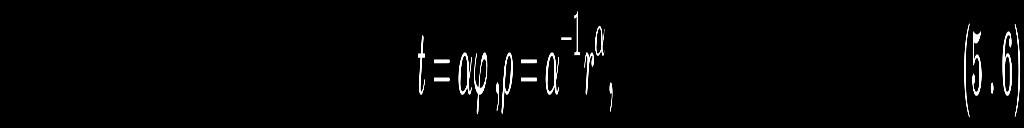

None
torch.Size([1, 128, 1024])


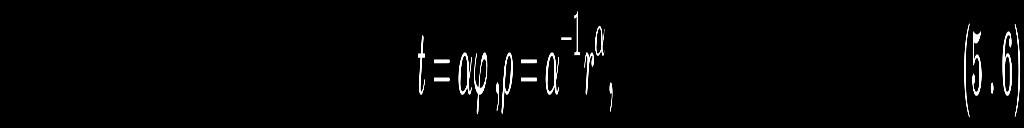

None

Predicted formula:
 <S> t = \alpha \varphi \, \rho = \alpha ^ { - 1 } r ^ { 0 } \, , \tag { 5 . 6 } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


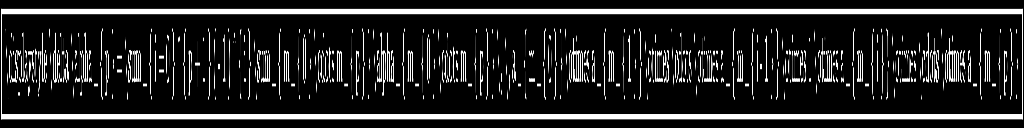

None
torch.Size([1, 128, 1024])


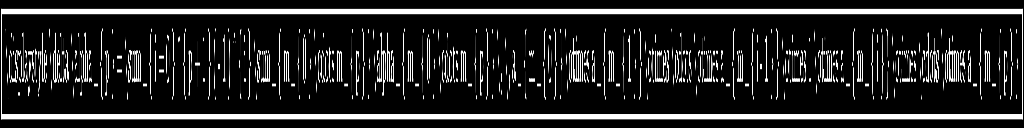

None

Predicted formula:
 <S> \fbox { { \frac { 1 } { 2 } } ( { \cal H } ) ^ { 2 } ( { \cal H } ) ^ { 2 } ( { \cal H } ) ^ { 2 } ( { \cal H } ) ^ { 2 } ( { \cal H } ) ^ { 2 } ( { \cal H } ) ^ { 2 } ( { \cal H } _ { 0 } ) ^ { 2 } ( { \cal H } _ { 0 } ) ^ { 2 } ( { \cal H } _ { 0 } ) ^ { 2 } ( { \cal H } _ { 0 } ) ^ { 2 } ( {


<IPython.core.display.Math object>

None


In [16]:
for image in IMAGES:
    predict(image)

In [ ]:
for image in IMAGES:
    predict_simple(image)

In [ ]:
for image in IMAGES:
    predict_scaled(image)